# GeekBrains
## Машинное обучение в бизнесе
## ДЗ Урока 3 (Связь бизнес-показателей и DS-метрик)
### Виталий Казанцев

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as  sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss, confusion_matrix

%matplotlib inline

In [2]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

__Функция для roc кривой__

In [3]:
def show_roc_curve(y_test, y_pred):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_pred, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()

__Функция для валидации__

In [4]:
def validate_model(model, X_train, X_test, y_train, y_test):
    # CV
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)

    # Train model and predict
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    # Find optimal threshold
    beta = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_pred)
    f1 = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    ix = np.argmax(f1)

    # Show ROC curve
    show_roc_curve(y_test, y_pred)

    # Return metrics
    return {'precision': precision[ix],
            'recall': recall[ix],
            'f1_score': f1[ix],
            'roc_auc': roc_auc_score(y_test, y_pred),
            'cv_roc_auc': cv_score,
            'cv_roc_auc_std': cv_score_std}

In [5]:
df = pd.read_csv('../Lection3/train_case2.csv', ';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


/home/vitaly/anaconda3/envs/venvLDS/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
df.tail()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1
69999,99999,20540,1,170,72.0,120,80,2,1,0,0,1,0


In [7]:
df.shape

(70000, 13)

Делим выборку на тренировочную и тестовую

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['cardio']), 
                                                    df['cardio'],
                                                    random_state=0)

In [9]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

# Объединяем пайплайны признаков в один
features = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)

__Задание 1, 2, 3:__

In [10]:
metrics = pd.DataFrame(columns=['precision', 'recall', 'f1_score', 'roc_auc', 'cv_roc_auc', 'cv_roc_auc_std'])


__Логистическая регрессия__

In [11]:
mdl_logreg = Pipeline([
    ('features', features),
    ('classifier', LogisticRegression(random_state=42))
])

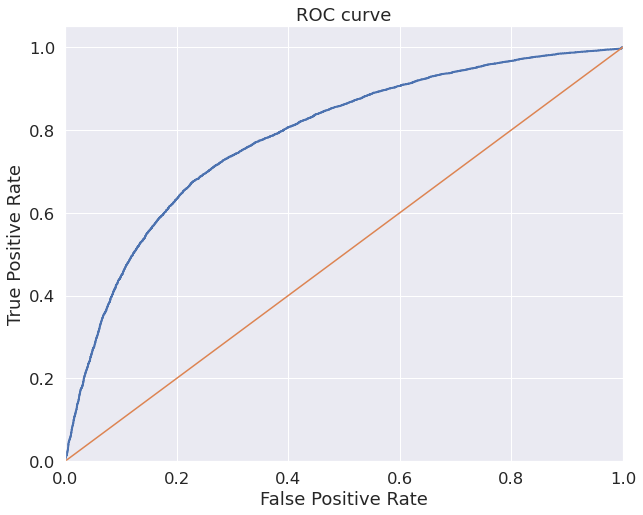

In [12]:
mt_log = validate_model(mdl_logreg, X_train, X_test, y_train, y_test)
metrics = metrics.append(mt_log, ignore_index=True)

__Random Forest:__

In [13]:
mdl_rf = Pipeline([
    ('features', features),
    ('classifier', RandomForestClassifier(random_state=42)),
])

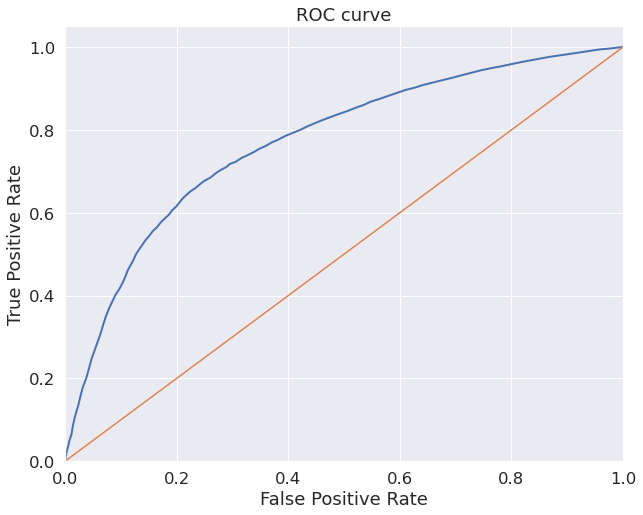

In [14]:
mt_log = validate_model(mdl_rf, X_train, X_test, y_train, y_test)
metrics = metrics.append(mt_log, ignore_index=True)

__Градиентный бустинг:__

In [15]:
mdl_gb = Pipeline([
    ('features', features),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

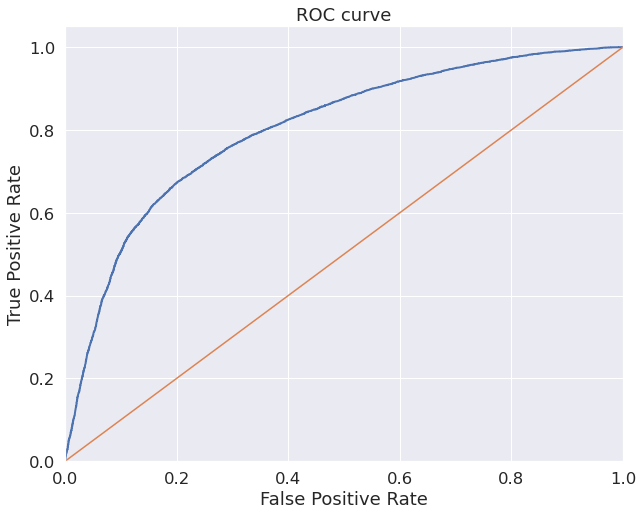

In [16]:
mt_log = validate_model(mdl_gb, X_train, X_test, y_train, y_test)
metrics = metrics.append(mt_log, ignore_index=True)

In [17]:
metrics.index = ['LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier']
metrics

,precision,recall,f1_score,roc_auc,cv_roc_auc,cv_roc_auc_std
LogisticRegression,0.647431,0.837558,0.730323,0.784035,0.786450,0.004705
RandomForestClassifier,0.642669,0.815553,0.718863,0.771037,0.774612,0.002827
GradientBoostingClassifier,0.697848,0.788134,0.740248,0.802615,0.802095,0.003615


__Задание 4__

Ответ зависит от того какие метрики будут более важными. Думаю, что при определении ССЗ важным будет минимизировать FP, тогда можно считать что модель логистической регрессии справилась с данной задачей лучше остальных, т.к. у этой модели лучшие показания по recall. Если же нужно минимизировать FN тогда из представленных моделй лучше выбрать модель градиентного бустинга.